In [1]:
#%matplotlib notebook  
from matplotlib import pyplot as plt
import numpy as np
import pasttrec_ctrl as ptc
import json
import sigproc_kit
import tdc_daq as td
import baseline_calib
import ROOT

from my_utils import *

def fwhm(x,y):
  dummy, t1, tot = sigproc_kit.discriminate(x,y,np.max(y)/2.,0,0)
  return tot

def hist_rms(x,y):
  counts = np.sum(y)
  weights = y / counts
  mean = np.dot(x,weights)
  deviations = x - mean
  return np.sqrt(  np.dot(deviations**2,weights)   )
def list_rms(x):
  mean = sum(x)/len(x)
  deviations = x - mean
  return np.sqrt(  sum(deviations**2) /len(x)  )
def list_mean(x):
  mean = sum(x)/len(x)
  return mean

Welcome to JupyROOT 6.14/04


------------> peaking time =  15 , gain =  4
 individual baseline scan 


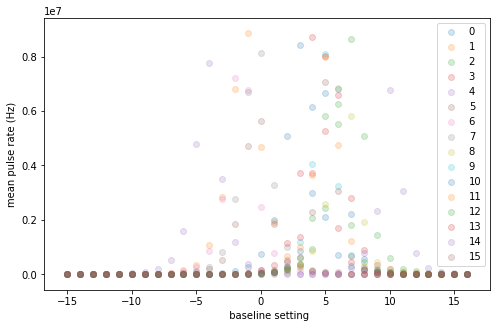

0021 average(16chan) noise thresh: mean =  3.38  +-  3.677   |  RMS  =  1.411  +-  0.153


>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reache

In [2]:
## scan threshold of all boar
from functools import (reduce)
from math import (sqrt)
import numpy as np
import time
import tdc_daq as td
import matplotlib.pyplot as plt
import db



# rootMeanSquare :: [Num] -> Float
def rootMeanSquare(xs):
    return sqrt(reduce(lambda a, x: a + x * x, xs, 0) / len(xs))
def MeanArrays(xs,ys):
    return np.dot(xs,ys)/sum(ys)

# ptime_list = [ 10, 15, 20 ]
ptime_list = [ 15 ]
# pt_gain_list = [ 1, 2, 4 ]
pt_gain_list = [4]  

for my_board in db.board_list():
  db.set_standby_board(my_board) #name = "0029" #PASSTEC board id (inside )

#used_boards = [ "0005", "0017", "0014", "0025" ]
#used_boards = [ "0101", "0102", "0103", "0010" , "0009", "0004", "0025"]
used_boards = ["0021"]
#used_boards = ["0101"]
#, "0010", "0102", "0103"]
nscans = 1
n_scan_steps = len(ptime_list)*len(pt_gain_list)*nscans

plt.rcParams["figure.figsize"] = (8,5)
trendtime_list = []
rmsAverageTrend_list = []
rmsAverageTrendError_list = []
meanAverageTrend_list = []
meanAverageTrendError_list = []

mean_scans = [[] for i in range(n_scan_steps) ] 
rms_scans = [[] for i in range(n_scan_steps) ] 

scaler_list_channel = [[[] for i in range(n_scan_steps) ]  for i in range(16)] 
   


scan_step = -1
for scan in range(0,nscans): 
 for ptime in ptime_list: 
  for pt_gain in pt_gain_list:     
   scan_step += 1 
   print("------------> peaking time = ", ptime, ", gain = ", pt_gain)
   for name in used_boards: 
    db.unset_standby_board(name)
    td.enable_tdc_channels_of_active_boards()
    ptc.init_active_boards()
   
    #time.sleep(60)
    trendtime_list += [ name ]
    ptc.init_boards_by_name(used_boards, ptime, pt_gain)   
   
    #### baseline scan, all channels in parallel (same baseline set to all channels at once):
    if scan == 2:
        print(" parallel baseline scan ")        
        baseline_calib.baseline_calib_by_noise(name, dummy_calib=True) 
    #### baseline scan each channel individual, while other channels are "inactive", = baseline is minimal -15 or (maximal +15)
    if scan == 1:
        print(" individual baseline scan ")
        baseline_calib.baseline_calib_by_noise(name, dummy_calib=True,individual=True) 
    if scan == 0:
        print(" individual baseline scan ")
        baseline_calib.baseline_calib_by_noise(name, dummy_calib=True,individual=True,baseline_inactive=-14)
#     calib       = db.get_calib_json_by_name(name)
    dummy_calib = db.get_calib_json_by_name(name,dummy_calib=True)
#     board_info  = db.find_board_by_name(name)

    #print(json.dumps(dummy_calib,indent=2, sort_keys=True))
    tsbl_scan_raw = dummy_calib["noise_scan_raw"]
    tsbl_range    = dummy_calib["bl_range"]

#     scaler_list = []
#     scaler_list = td.scaler_rate_of_board(name,0.2)
    

    for i in range(0,16):
     plt.scatter(tsbl_range,tsbl_scan_raw[i],alpha=0.2,label = "{:d}".format(i))

     plt.legend()
     plt.xlabel("  baseline setting ")
     plt.ylabel("mean pulse rate (Hz)")
     #plt.yscale('log') 
    plt.show()


    fwhm_list = []
    max_list  = []
    rms_list = []
    mean_list = []
    for i in range(0,16):
      fwhm_list += [ fwhm(tsbl_range,tsbl_scan_raw[i]) ]
      rms_list += [ hist_rms(tsbl_range,tsbl_scan_raw[i]) ]
      mean_list += [ MeanArrays(tsbl_range,tsbl_scan_raw[i]) ]  
      max_list  += [ np.max(tsbl_scan_raw[i])  ]
      scaler_list_channel[i][scan_step] = tsbl_scan_raw[i] 
    mean_scans[scan] = mean_list
    rms_scans[scan]= rms_list    
    fwhm_list = np.array(fwhm_list)
    max_list  = np.array(max_list)
    
    print(name, "average(16chan) noise thresh: mean = ", round(sum(mean_list)/len(mean_list),3), " +- ", round(list_rms(mean_list),3), "  |  RMS  = ", round(sum(rms_list)/len(rms_list),3), " +- ", round(list_rms(rms_list),3) )

    meanAverageTrend_list += [ sum(mean_list)/len(mean_list) ]
    meanAverageTrendError_list += [ list_rms(mean_list) ]
    rmsAverageTrend_list += [ sum(rms_list)/len(rms_list) ]
    rmsAverageTrendError_list += [ list_rms(rms_list) ]    
    



channel :  0


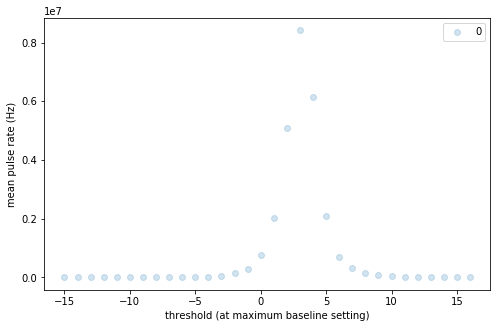

channel :  1


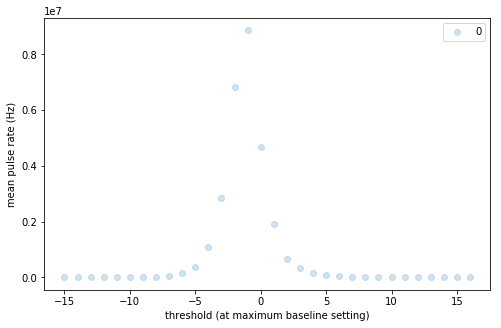

channel :  2


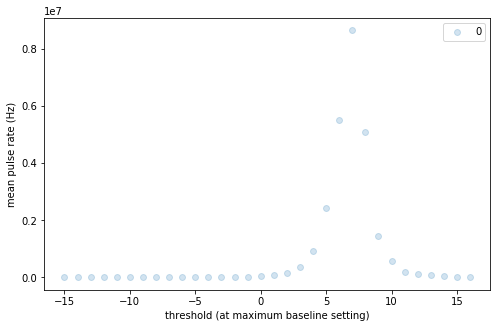

channel :  3


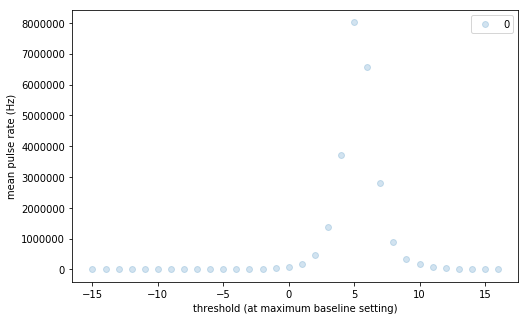

channel :  4


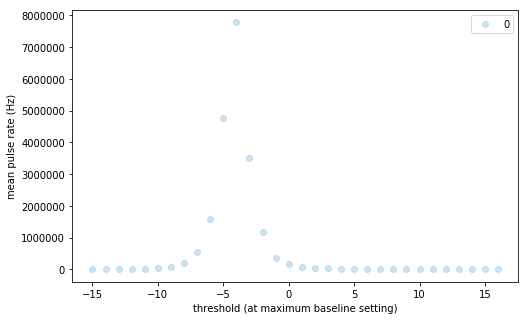

channel :  5


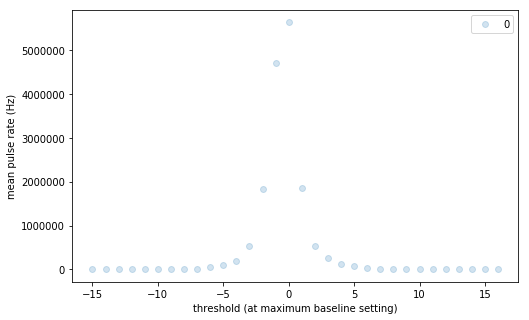

channel :  6


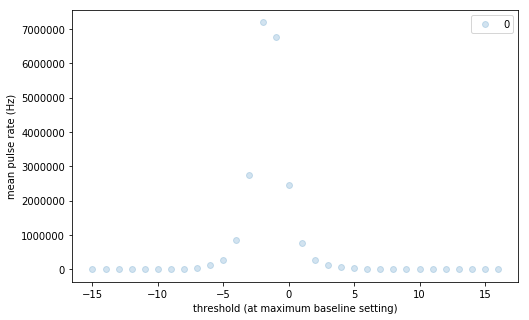

channel :  7


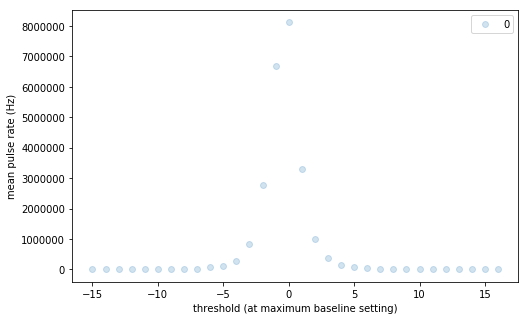

channel :  8


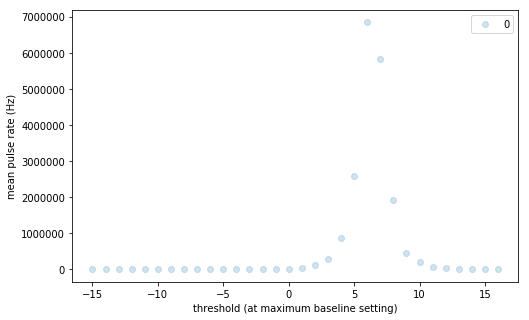

channel :  9


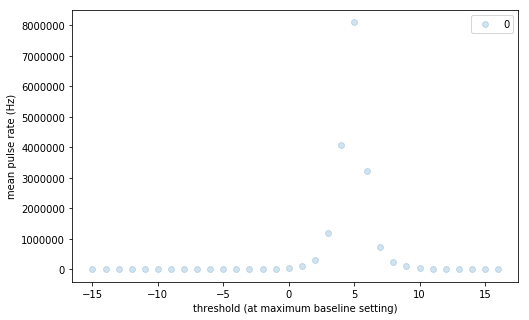

channel :  10


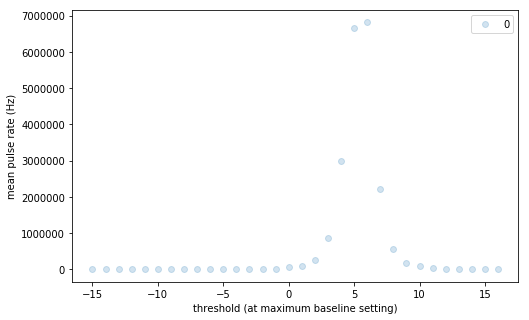

channel :  11


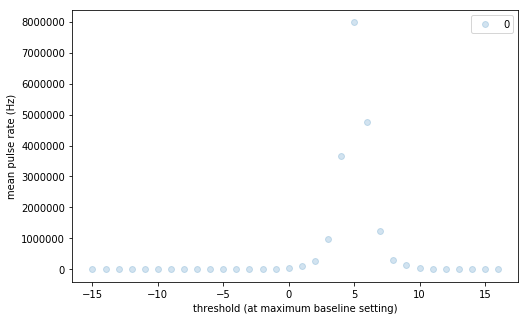

channel :  12


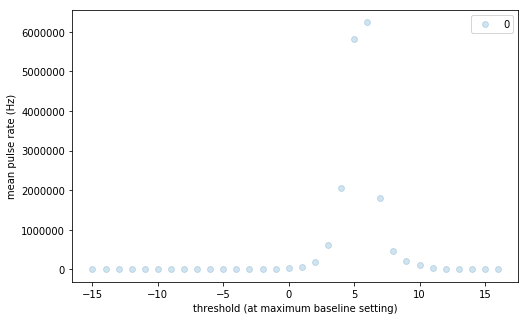

channel :  13


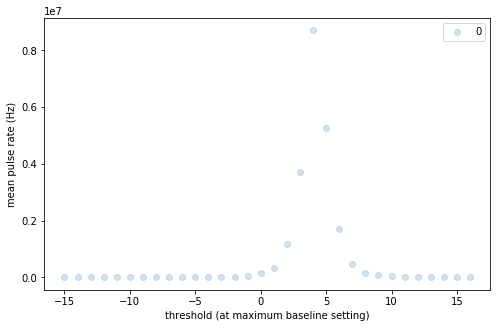

channel :  14


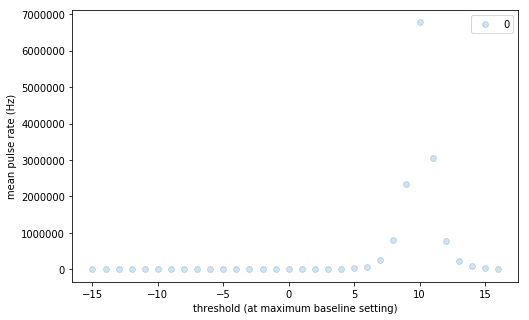

channel :  15


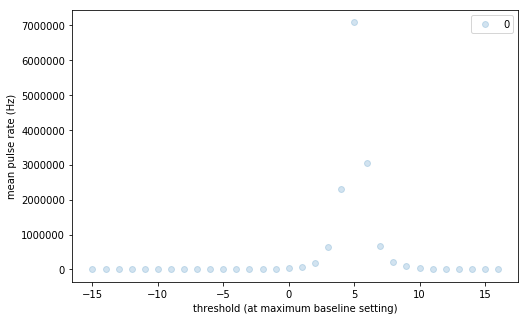

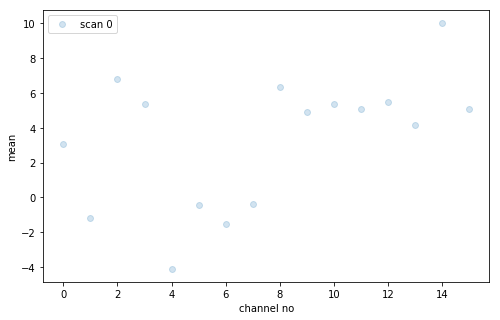

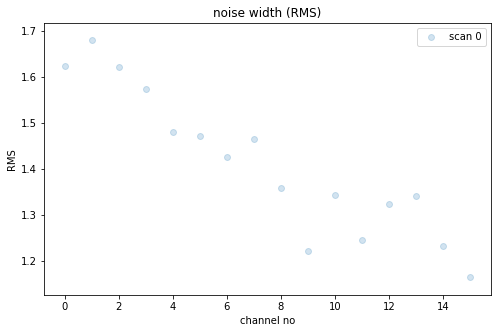

In [3]:
for ch in range(0,16):
    print("channel : ",ch)
    for i in range(0,len(scaler_list_channel[ch])):
     plt.scatter(tsbl_range,scaler_list_channel[ch][i],alpha=0.2,label = "{:d}".format(i))

     plt.legend()
     plt.xlabel("threshold (at maximum baseline setting)")
     plt.ylabel("mean pulse rate (Hz)")
     #plt.yscale('log') 
    plt.show()
for scan in range(0,nscans): 
    plt.scatter(list(range(0,len(mean_scans[scan]))), mean_scans[scan],alpha=0.2,label = "scan {:d}".format(scan))
    plt.xlabel("channel no")
    plt.ylabel("mean")
plt.legend()
plt.show()
for scan in range(0,nscans): 
    plt.scatter(list(range(0,len(mean_scans[scan]))), rms_scans[scan],alpha=0.2,label = "scan {:d}".format(scan))
    plt.xlabel("channel no")
    plt.ylabel("RMS")
    plt.title("noise width (RMS)")
plt.legend()
plt.show()

In [6]:
archive(label="baseline_individual_scan_board0021_4xLVDS-Ferrites")

archived to ./archive/2020-06-10_15-39-08_noise_scan_baseline_individual_channels_baseline_individual_scan_board0021_4xLVDS-Ferrites


In [5]:



plt.rcParams["figure.figsize"] = (8,15)
for ch in range(0,16):
    print("channel : ",ch)
    for i in range(0,len(scaler_list_channel[ch])):
     nums = np.array(scaler_list_channel[ch][i])*10**(16-ch)
     plt.scatter(tsbl_range,nums,alpha=0.2,label = "{:d}".format(baseline[i]))

     #plt.legend()
     plt.xlabel("threshold (at maximum baseline setting)")
     plt.ylabel("mean pulse rate (Hz)")

plt.yscale('log') 
plt.ylim(ymax = 1E24, ymin = 1E1)
plt.show()

channel :  0


NameError: name 'baseline' is not defined